In [5]:
import twitter, datetime
import json
import pymongo
from dotenv import load_dotenv 
import os 
import pandas
import preprocessor as p
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

load_dotenv()                  

mongo = os.environ.get('mongo')
db = os.environ.get('db')
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
hashtags = {'JohnsonAndJohnsonVaccine': ['JnJVaccine', 'JohnsonAndJohnsonVaccine'],
            'PfizerVaccine': ['PfizerVaccine', 'Pfizer'],
            'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
            'Vaccinated': ['Vaccinated']
        }
# hashtags = {'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
#             'Vaccinated': ['Vaccinated'] }

def oauth_login():
    '''
    A static method to authenticate user
    It uses OAuth2.0 specification which takes a bearer token to authenticate user
    '''

    CONSUMER_KEY = os.environ.get('CONSUMER_KEY')
    CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
    BEARER_TOKEN= os.environ.get('BEARER_TOKEN')
    
    auth = twitter.OAuth2(CONSUMER_KEY, CONSUMER_SECRET, BEARER_TOKEN)
    api = twitter.Twitter(auth=auth)
    return api

def clean_results(result, topic):
    '''
    To take required text for NLP, may change later as per the requirement
    '''
    final = []
    for arr in result["statuses"]:
        obj = dict()
        obj["tweet"] = arr["text"]
        obj["id"] = arr["id_str"]
        obj["name"] = arr["user"]["name"]
        obj["location"] = arr["user"]["location"]
        obj["topic"] = topic
        obj["created_at"] = arr["created_at"]
        obj["processed_on"] = datetime.datetime.now().isoformat(' ', 'seconds')
        final.append(obj)
    return final

def save_tweets_csv(tweets, topic):
    '''
    This method will help us on saving tweets
    '''
    try:
        fieldnames = list(tweets[0].keys())
        output_dir = os.path.join('data', 'csv')
        output_file = os.path.join(output_dir, topic+'.csv')
        if not os.path.exists(output_file):
            open(output_file, 'w').close()
        file_empty = os.stat(output_file).st_size == 0
        with open(output_file, mode='a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
            if file_empty:
                writer.writeheader() 
            writer.writerows(tweets)
        print("done inserting")
    except Exception as e:
        print(e)

def query_tweet(query, count, topic):
    '''
    Queries and finds tweet for different hashtags/topic, it will keep on searching until it finds total count
    '''
    api = oauth_login()
    meta = query.split("-RT")[0].split('#')[1]
    result = api.search.tweets(q=query, count=500)
    print(result["search_metadata"])
    save_tweets_csv(clean_results(result, meta), topic)
    result_count = result["search_metadata"]["count"]
    next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
    while result_count < count:
        result = api.search.tweets(q=query, include_entities='true',max_id=next_max_id, count=500 )
        print(result["search_metadata"])
        print(result_count)
        save_tweets_csv(clean_results(result, meta), topic)
        result_count += result["search_metadata"]["count"]
        if "next_results" in result["search_metadata"]:
            next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
        else:
            break
        
def get_docs_csv():   
    client = pymongo.MongoClient(mongo)
    database = client[db]
    for col in topics:
        coll = database[col] 
        try:
            result = coll.find()
            
            fieldnames = list(result[0].keys())
            fieldnames.remove('_id')

            output_dir = os.path.join('data', 'csv')
            output_file = os.path.join(output_dir, col+'.csv')
            with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
                writer.writeheader()
                writer.writerows(result)

        except Exception as e:
            print(e)

def remove_punctuations(text):
    punct =['%','/',':','\\','&amp;','&',';']
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

def get_value_counts(col_name, analyzer_name, tweets_df):
    '''
    This function returns count of the dataset passed, it uses pandas library to do the same
    '''
    count = pandas.DataFrame(tweets_df[col_name].value_counts())
    percentage = pandas.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    counts = pandas.concat([count, percentage], axis = 1)
    counts = counts.reset_index()
    counts.columns = ['sentiment', 'counts', 'percentage']
    counts.sort_values('sentiment', inplace = True)
    counts['percentage'] = counts['percentage'].apply(lambda x: round(x,2))
    counts = counts.reset_index(drop = True)
    counts['analyzer'] = analyzer_name
    return counts

def fetch_tweets():
    '''
    This method fetches and stores the tweets for the last seven days and store it in the mongodb
    '''
    try:
        for key in hashtags.keys():
            for topic in hashtags[key]:
                query_tweet("#"+ topic+" -RT AND lang:en", 10000, key)
        print("Done fetching tweets")
    except Exception as e:
        print(e)

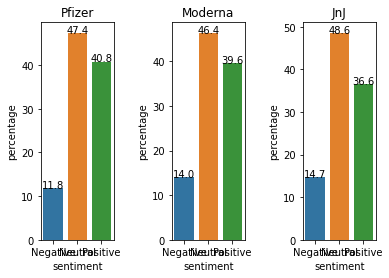

In [6]:
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine", "Vaccinated"]
# topics = ["ModernaVaccine"]
final_bar = []
result_copy = dict()
for topic in topics:          
        file_dir = os.path.join('data', 'csv')
        file = os.path.join(file_dir, topic+'.csv')
        result = pandas.read_csv(file)
        result.sort_values(by="created_at")
        result_copy[topic] = result.copy()
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet'].apply(lambda x: p.clean(x))
        result_copy[topic].drop_duplicates(subset='tweet_cleaned', keep='first', inplace=True)

        # remove punctuations
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: remove_punctuations(x))

        # Drop tweets which have empty text field
        result_copy[topic]['tweet_cleaned'].replace('', np.nan, inplace=True)
        result_copy[topic]['tweet_cleaned'].replace(' ', np.nan, inplace=True)
        result_copy[topic].dropna(subset=['tweet_cleaned'], inplace=True)

        result_copy[topic] = result_copy[topic].reset_index(drop=True)

        #sentiment analysis
        # Obtain polarity scores generated by TextBlob
        result_copy[topic]['textblob_score'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
        # neutral_thresh = 0.05

        # Convert polarity score into sentiment categories
        result_copy[topic]['textblob_sentiment'] = result_copy[topic]['textblob_score'].apply(lambda c: 'Positive' if c >= 0.02 else ('Negative' if c <= -(0.02) else 'Neutral'))
        
        textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob', result_copy[topic])

        final_bar.append(textblob_sentiment_df)

# bargraph plotting
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)

plt.rcParams["figure.figsize"] = (17,8)

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Pfizer")
for index, row in final_bar[2].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[2], ax=ax)

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Moderna")
for index, row in final_bar[0].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[0], ax=ax)

ax = fig.add_subplot(1, 3, 3)
ax.set_title("JnJ")
for index, row in final_bar[1].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[1], ax=ax)

plt.show()



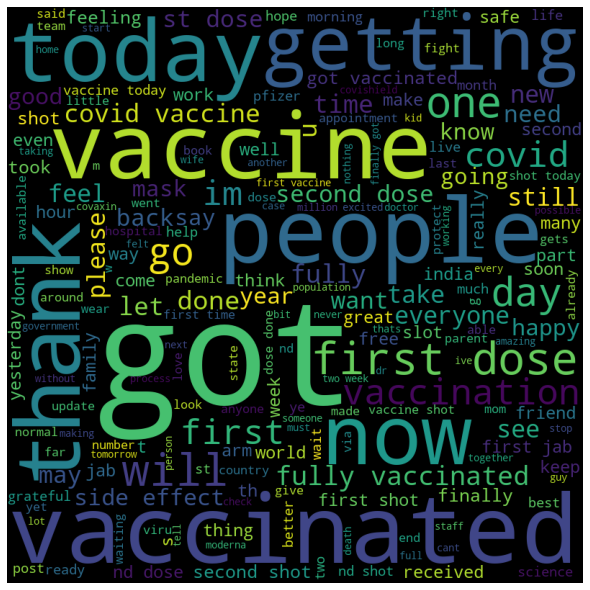

In [7]:
#worldcloud
#vaccinated
comment_words = ''
stopwords = set(STOPWORDS)
for val in result_copy['Vaccinated'].values:
    row = val[7]
    tokens = row.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

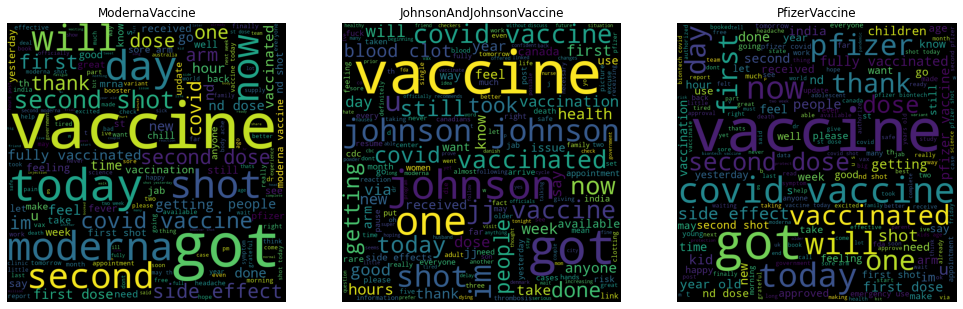

In [8]:
#worldcloud
#vaccinated
comment_words_arr = []
stopwords = set(STOPWORDS)
for j in range(0,3):
    comment_words = ''    
    for val in result_copy[topics[j]].values:
        row = val[7]
        tokens = row.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
    comment_words_arr.append(comment_words)

fig = plt.figure()
for i in range(0,3):
    ax = fig.add_subplot(1,3, i+1)
    ax.title.set_text(topics[i])  
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words_arr[i])
    # plt.figure(figsize = (7, 7), facecolor = None, )
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

In [9]:
#Scatterplot for pfizer
# x = [2,2,8,1,15,8,12,9,7,3,11,4,7,14,12]
# y = [100,105,84,105,90,99,90,95,94,100,79,112,91,80,85]
# plt.scatter(x, y)   

# plt.show()

<AxesSubplot:>

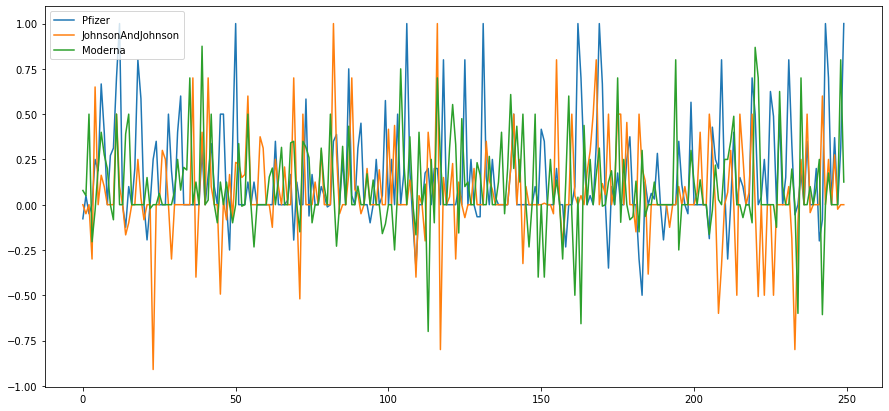

In [10]:
# plotly for all the vaccines
import plotly.express as px

plotly = []
arr_Pfizer = (result_copy['PfizerVaccine']['textblob_score'].head(250)).tolist()
arr_JnJ = (result_copy['JohnsonAndJohnsonVaccine']['textblob_score'].head(250)).tolist()
arr_Moderna = (result_copy['ModernaVaccine']['textblob_score'].head(250)).tolist()
# print(arr_Pfizer)
plotly.append(arr_Pfizer)
plotly.append(arr_JnJ)
plotly.append(arr_Moderna)
plotly = [[plotly[j][i] for j in range(len(plotly))] for i in range(len(plotly[0]))]
df_1 = pandas.DataFrame(plotly, columns=['Pfizer','JohnsonAndJohnson','Moderna'])
df_1.plot(figsize = (15, 7))

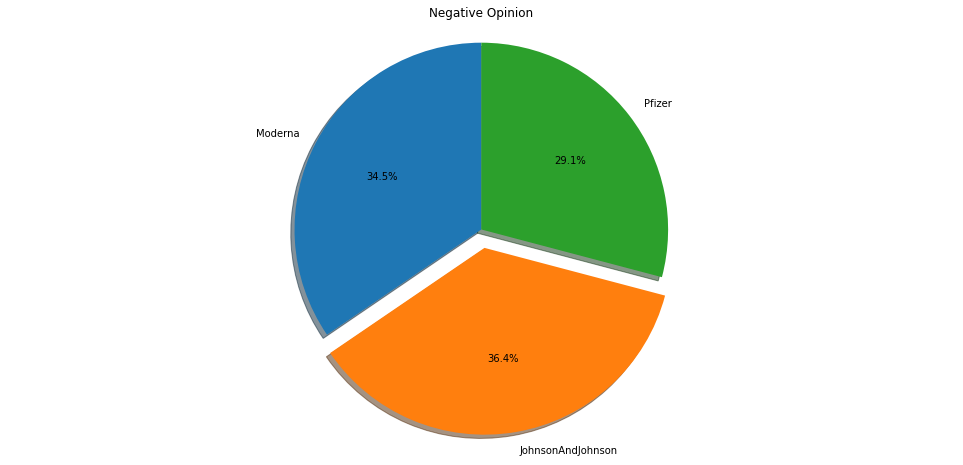

In [11]:
# Pie Chart
labels = 'Moderna', 'JohnsonAndJohnson', 'Pfizer'
negativity = 0
sizes = []
for i in range(0,3):
    negativity += final_bar[i]['percentage'][0]

for i in range(0,3):
    sizes.append(round((final_bar[i]['percentage'][0]/negativity)*100,2))

explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, )
ax1.set_title('Negative Opinion')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [12]:
state_codes = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", 
          "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", 
          "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", 
          "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
        
states_mapping = { "Alabama": "AL", "Alaska": "AK", "Arizona" : "AZ", "Arkansas": "AR", "California": "CA", 
    "Colorado": "CO", "Connecticut": "CT", "Washington DC": "DC", "Delaware": "DE", "Florida": "FL", 
    "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", 
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", 
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", 
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", 
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", 
    "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", 
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", 
    "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",  
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY" }

for topic in topics:
    for index, row in result_copy[topic].iterrows():
        flag = 0
        if row.location:
            location_split = str(row.location).split(',')
            for word in location_split:
                word = word.strip()
                for state, code in states_mapping.items():
                    if state == word.title() or code == word:
                        result_copy[topic].at[index, 'us_state_code'] = code
                        result_copy[topic].at[index, 'us_state'] = state
                        flag = 1
                        break
                if flag == 1:
                    break

result_states = {}
for topic in topics:
    result_states[topic] = result_copy[topic][result_copy[topic]['us_state_code'].notna()]

In [13]:
df_states = dict()
state_df = dict()
for topic in topics:
    df_states[topic] = []
    for i in state_codes:
        dic = {'State':i, 'Positive':0, 'Negative':0, 'Neutral': 0}
        df_states[topic].append(dic)
    # now update
    for ind,row in result_states[topic].iterrows():
        curr_state = row['us_state_code']
        for item in df_states[topic]:
            if item['State'] == curr_state:
                item[row['textblob_sentiment']] = item[row['textblob_sentiment']] + 1
                break

    #positive percentage
    for row in df_states[topic]:
        curr_total = int(row['Positive']) + int(row['Negative']) + int(row['Neutral'])
        row.setdefault('Total',curr_total)
        if curr_total > 0:
            row.setdefault('PositivePercentage', round(float(row['Positive']/row['Total']*100),2))
            row.setdefault('NegativePercentage', round(float(row['Negative']/row['Total']*100),2))
        else:
            row.setdefault('PositivePercentage',0)
            row.setdefault('NegativePercentage',0)
    # print(pandas.DataFrame(df_states[topic]))
    state_df[topic]  = pandas.DataFrame(df_states[topic])

    fig = px.choropleth(state_df[topic], locations='State', locationmode='USA-states', 
            scope='usa', color = 'PositivePercentage', hover_name='State', hover_data=['Positive','Negative','Neutral'], range_color= [10,90], color_continuous_scale= px.colors.diverging.BrBG, title='Covid-19 Vaccine Positive Sentiment - '+topic )
    fig.show()


In [17]:
#Negative Sentiment
for topic in topics:
    fig = px.choropleth(state_df[topic], locations='State', locationmode='USA-states', 
            scope='usa', color = 'NegativePercentage', hover_name='State', hover_data=['Positive','Negative','Neutral'], range_color= [10,90], color_continuous_scale= ["pink", "red", "blue"], title='Covid-19 Vaccine Negative Sentiment - '+topic )
    fig.show()


In [15]:
result_states['PfizerVaccine'].head(10)

,tweet,id,name,location,topic,created_at,processed_on,tweet_cleaned,textblob_score,textblob_sentiment,us_state_code,us_state
3,Got my 2nd @pfizer #FauciOuchie 27 hrs ago &am...,1390072232764977155,Jessie,"Florida, USA",PfizerVaccine,Wed May 05 22:33:41 +0000 2021,2021-05-05 19:14:10,Got my nd hrs ago have been looking over my s...,0.000000,Neutral,FL,Florida
5,I am so damn excited to get my second #PfizerV...,1390070969524445186,ACupOfPissedMiss,"Kansas, USA",PfizerVaccine,Wed May 05 22:28:40 +0000 2021,2021-05-05 19:14:10,I am so damn excited to get my second dose tom...,0.187500,Positive,KS,Kansas
9,My Wife &amp; I are both fully vaccinated! We ...,1390068930656493573,Heather Minotti 🌊🌈,"Buffalo, NY",PfizerVaccine,Wed May 05 22:20:33 +0000 2021,2021-05-05 19:14:10,My Wife I are both fully vaccinated! We had o...,0.271429,Positive,NY,New York
14,is it normal to be tired about your second dos...,1390066009982255106,marissa she/her,"Pittsburgh, PA",PfizerVaccine,Wed May 05 22:08:57 +0000 2021,2021-05-05 19:14:10,is it normal to be tired about your second dos...,-0.125000,Negative,PA,Pennsylvania
17,If anyone wants to follow this whole bizzaro t...,1390061573847273472,✨Crystal ✨,"Kentucky, USA",PfizerVaccine,Wed May 05 21:51:19 +0000 2021,2021-05-05 19:14:10,If anyone wants to follow this whole bizzaro t...,0.200000,Positive,KY,Kentucky
19,"I’m fully vaccinated!! Yay!! Also, our friendl...",1390052348509175812,Sheri & Molly O 🌈,"Winston-Salem, NC, USA",PfizerVaccine,Wed May 05 21:14:40 +0000 2021,2021-05-05 19:14:10,"Im fully vaccinated!! Yay!! Also, our friendly...",0.585938,Positive,NC,North Carolina
20,second shot DONE! 💕 now time for a day of rest...,1390047389378023424,Kayla,"Alabama, USA",PfizerVaccine,Wed May 05 20:54:58 +0000 2021,2021-05-05 19:14:10,second shot DONE! now time for a day of rest w...,0.000000,Neutral,AL,Alabama
26,I heard the vaccine helps with the gainz! \n\n...,1390043400036966400,Coach Perez 🇵🇷,"Los Angeles, CA",PfizerVaccine,Wed May 05 20:39:06 +0000 2021,2021-05-05 19:14:10,I heard the vaccine helps with the gainz! 2 Co...,0.000000,Neutral,CA,California
29,Just got vaccinated! Hope you all do too so we...,1390040047991336969,⚾️Phillies and Sixers Fan🏀 (15-15) (44-21),"Doylestown, PA",PfizerVaccine,Wed May 05 20:25:47 +0000 2021,2021-05-05 19:14:10,Just got vaccinated! Hope you all do too so we...,0.187500,Positive,PA,Pennsylvania
37,Vaccine company's stocks are tanking in the wa...,1390035122871836674,📷📷📷David Hersh📷📷📷,"Rochester, MN",PfizerVaccine,Wed May 05 20:06:13 +0000 2021,2021-05-05 19:14:10,Vaccine company's stocks are tanking in the wa...,0.000000,Neutral,MN,Minnesota
